In [1]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
print(tf.__version__)

2.0.0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%cd drive/'My Drive'/BME590_Machine_Learning

/content/drive/My Drive/BME590_Machine_Learning


In [0]:
from scipy.io import loadmat
data = loadmat('OASBUD.mat')['data'][0] # mat file is dict with header, we just want the data key (which is stored as a list of lists)
# each of the 100 data points consists of 7 arrays
# array 0: patient's unique ID
# array 1: first scan plane (first set of rf dta)
# array 2: second scan plane (second set of rf data)
# array 3: region of interest for first scan plane
# array 4: region of interest for second scan plane
# array 5: BI-RADS category (low, medium, high probability of malignancy)
# array 6: label (0 = benign, 1 = malignant)

In [0]:
from scipy.signal import hilbert

# Define preprocessing functions: convert raw radiofrequency (rf data) to ultrasound image
def preprocessing(rf_data, db_threshold=50):
    # Use hilbert function to create a dB envelope image of the data
    # Then sets any dB value of the matrix less than the threshold to the threshold
    envelope_image = np.abs(hilbert(rf_data))
    envelope_image = 20 * np.log10(envelope_image/np.max(envelope_image))
    envelope_image[envelope_image < -1.0*db_threshold] = -1.0*db_threshold
    return 255.0*(envelope_image + db_threshold)/(db_threshold)    
    # return envelope_image
    
# For purposes of physical layer, split the applying of the dB threshold to a separate tf function to be called when training the model
# Not used in this notebook (functionality covered by the above preprocessing function)
def apply_cutoff(envelope_image, db_threshold):
    multiplier = -1.0*db_threshold
    envelope_image = tf.cast(envelope_image, 'float32')
    mask = tf.less(envelope_image, multiplier*tf.ones_like(envelope_image))
    mask = tf.cast(mask, 'float') 
    mask = mask * multiplier
    envelope_image = tf.multiply(envelope_image, tf.cast(tf.greater_equal(envelope_image, multiplier), 'float')) + mask
    return 255.0*(envelope_image + db_threshold)/(db_threshold)    


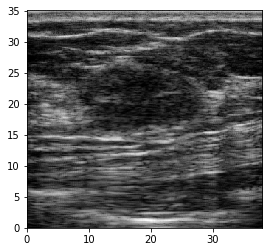

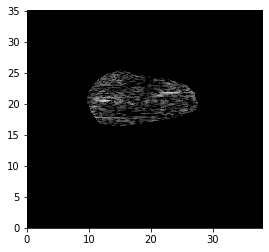

In [7]:
# example image processing of first data point:
c = 1540
width = 38
fs = 40e6
rf1 = data[0][1]
rf2 = data[1][1]
roi1 = data[0][3]
  
import skimage
p = [skimage.transform.resize(preprocessing(rf1), (320, 320)), skimage.transform.resize(preprocessing(rf2), (320,320))]
# print(p.shape)
preprocessed=apply_cutoff(p,50)
plt.imshow(preprocessed[0],extent=[0,width,0,rf1.shape[0]*500*c/fs],cmap='gray')
plt.show()
preprocessed2=preprocessing(rf1)*roi1
plt.imshow(preprocessed2,extent=[0,width,0,rf1.shape[0]*500*c/fs],cmap='gray')
plt.show()

In [0]:
# Clear some variables from memory
%reset_selective -f data, rf1, roi1, envelope_image, preprocessed

In [0]:
# to get data and labels for all scans
# Set dB cutoff values
dB_cutoff= 50
labeled_data = []
for n in range(len(data)):
  labeled_data.append((preprocessing(data[n][1], dB_cutoff), data[n][3], data[n][6][0])) # data for scan 1, roi for scan 1, label
  labeled_data.append((preprocessing(data[n][2], dB_cutoff), data[n][4], data[n][6][0])) # data for scan 2, roi for scan 2, label

In [0]:
# Data augmentation:
# semi-randomly crop the image to include the whole tumor several times
# resize the image to a square of given size (images start as rectangular matrices of differing dimensions)
# augment data with left-right flip and up-down flip

import random
import skimage

def new_augment_data(labeled_data):
  augmented_labeled_data = []
  new_im_size = 320
  for data in labeled_data:
    # Find boundaries of lesion (x0, x1, y0, y1)
    roi = data[1]
    x0 = 0
    while x0 < len(roi) and 1 not in roi[x0]:
      x0 += 1
    x1 = x0
    while x1 < len(roi) and 1 in roi[x1]:
      x1 += 1
    y0 = 0
    while y0 < len(roi[0]) and 1 not in roi[:,y0]:
      y0 += 1
    y1 = y0
    while y1 < len(roi[0]) and 1 in roi[:,y1]:
      y1 += 1
    # print(x0,x1,y0,y1)
    ctr = 0
    # On each side of the tumor, give some amount of buffer 
    # (max of 20 px for x, y is scaled to be as big as the cropped x or as big as the img dims)
    x_bound = np.min([x0, len(roi)-x1, 20])
    y_bound = np.min([y0, len(roi[0])-y1, x1-x0 - (y1-y0)])
    # 10 random crops per original image
    while ctr < 10:
      ctr += 1
      # amount of buffer on each side is random

      shift_x = random.randint(0, x_bound) 
      shift_y = random.randint(0, y_bound)
      if x1-x0 < len(roi[0]):
        new_im = data[0][x0-shift_x:x1+(20-shift_x), y0-shift_y:y1+(y_bound-shift_y)]
      else:
        new_im = data[0][x0-shift_x:x1+(20-shift_x), :]
      new_im = skimage.transform.resize(new_im, (new_im_size, new_im_size))
      # original cropped/resized image and two flipped -> 3x images
      augmented_labeled_data.append((new_im, data[2]))
      augmented_labeled_data.append((np.fliplr(new_im), data[2]))
      augmented_labeled_data.append((np.flipud(new_im), data[2]))
  # End with 30x num images
  return np.array(augmented_labeled_data)

augmented_labeled_data = new_augment_data(labeled_data)

In [11]:
# Affirm shapes of output
print(augmented_labeled_data.shape)
print(augmented_labeled_data[0][0].shape)

(6000, 2)
(320, 320)


In [0]:
# Randomly shuffle the dataset
random.shuffle(augmented_labeled_data)

In [0]:
# train_test_split (because the function was using a lot of ram for some reason)

x_train_class = augmented_labeled_data[:int(len(augmented_labeled_data)*.8),0]
y_train_class = augmented_labeled_data[:int(len(augmented_labeled_data)*.8),1]
x_test_class = augmented_labeled_data[int(len(augmented_labeled_data)*.8):,0]
y_test_class = augmented_labeled_data[int(len(augmented_labeled_data)*.8):,1]

In [14]:
# Affirm again shapes of arrays after splitting data
print(x_train_class.shape)
print(x_train_class[0].shape)
print(y_train_class.shape)

(4800,)
(320, 320)
(4800,)


In [0]:
# Expand list of tuples to matrix with an added axis
x_train_class = np.array([x for x in x_train_class])[..., np.newaxis]
x_test_class = np.array([x for x in x_test_class])[..., np.newaxis]


In [16]:
print(x_train_class.shape)

(4800, 320, 320, 1)


In [0]:
# Create train/test datasets
train_ds_class = tf.data.Dataset.from_tensor_slices((np.asarray(x_train_class, np.float32), np.asarray(y_train_class, np.float32))).shuffle(10000).batch(128)
test_ds_class = tf.data.Dataset.from_tensor_slices((np.asarray(x_test_class, np.float32), np.asarray(y_test_class, np.float32))).batch(int(len(x_test_class)/2))

In [0]:
# %reset_selective -f data, labeled_data, augmented_labeled_data, x_train_class, y_train_class

In [0]:
# Build custom CNN model
class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        # self.dBcutoff = dB_cutoff
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,strides=1, padding='same', activation=tf.nn.leaky_relu)
        # self.conv2 = tf.keras.layers.Conv2D(filters=32,kernel_size=3, strides=1,padding='same',activation=tf.nn.leaky_relu)
        self.mp1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,strides=1, padding='same', activation=tf.nn.leaky_relu)
        # self.conv4 = tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,padding='same',activation=tf.nn.leaky_relu)
        self.mp2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv5 = tf.keras.layers.Conv2D(filters=128, kernel_size=3,strides=1, padding='same', activation=tf.nn.leaky_relu)
        # self.conv6 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, strides=1,padding='same',activation=tf.nn.leaky_relu)
        self.mp3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(1000, activation=tf.nn.relu)
        self.do = tf.keras.layers.Dropout(.1)
        self.d2 = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    def call(self, x):
        x = self.conv1(x)
        # x = self.conv2(x)
        x = self.mp1(x)
        x = self.bn1(x)
        x = self.conv3(x)
        # x = self.conv4(x)
        x = self.mp2(x)
        x = self.bn2(x)
        x = self.conv5(x)
        # x = self.conv6(x)
        x = self.mp3(x)
        x = self.bn3(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.do(x)
        return self.d2(x)

model = CNN()

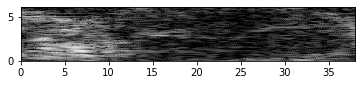

In [20]:
# See what images look like in x_train_class
rf1 = x_train_class[2,:,:,0]
plt.imshow(rf1,extent=[0,width,0,rf1.shape[0]*500*c/fs],cmap='gray')
plt.show()

In [22]:
# Set up training and testing step functions

tf.keras.utils.plot_model(model, show_shapes=True)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
        tf.print(tf.argmax(predictions, axis=1), summarize=-1)
        tf.print(labels, summarize=-1)
        tf.print("----")
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    tf.print("TEST:", tf.argmax(predictions, axis=1), summarize=-1)
    tf.print("TEST:", labels, summarize=-1)
    tf.print("----")
    test_loss(t_loss)
    test_accuracy(labels, predictions)
    

# Training the model
history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
EPOCHS = 5
for epoch in range(EPOCHS):
    i = 0
    for images, labels in train_ds_class:
        # print(images.shape)
        train_step(images, labels)

    for test_images, test_labels in test_ds_class:
        test_step(test_images, test_labels)
        template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
        print(template.format(epoch+1,
                            train_loss.result(),
                            train_accuracy.result()*100,
                            test_loss.result(),
                            test_accuracy.result()*100))
    history['loss'].append(train_loss.result().numpy())
    history['val_loss'].append(test_loss.result().numpy())
    history['accuracy'].append(train_accuracy.result().numpy())
    history['val_accuracy'].append(test_accuracy.result().numpy())
    print(history)
    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
----
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 1 0 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 

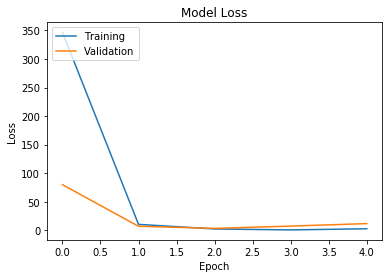

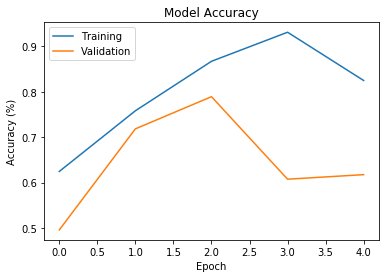

In [26]:
# Visualization
plt.plot([x.numpy() for x in history['loss']])
plt.plot([x.numpy() for x in history['val_loss']])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot([x.numpy() for x in history['accuracy']])
plt.plot([x.numpy() for x in history['val_accuracy']])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [30]:
print("train loss:", [x.numpy() for x in history['loss']])
print("test loss:", [x.numpy() for x in history['val_loss']])
print("train acc:", [x.numpy() for x in history['accuracy']])
print("test acc:", [x.numpy() for x in history['val_accuracy']])

train loss: [346.88208, 10.297211, 2.2734444, 0.5837569, 2.6266575]
test loss: [79.88168, 6.9663363, 3.2802343, 7.2996745, 11.641283]
train acc: [0.6245833, 0.758125, 0.8670833, 0.93104166, 0.82479167]
test acc: [0.49583334, 0.7183333, 0.7891667, 0.6075, 0.6175]


In [0]:
# Visualization
from sklearn.metrics import roc_curve
# BATCH_SIZE=128
# y_pred=[]
# for n in range(BATCH_SIZE):
  # for image, label in test_ds_class.take(n):
y_pred = np.array(model(x_test_class[:200])).ravel()
print(y_pred, type(y_test_class[:200]))
# y_pred=np.array(y_pred)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test_class[:200], y_pred, pos_label=1)
auc_keras = auc(fpr_keras, tpr_keras)

print(auc_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

plt.figure(2)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.figure(3)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
